# Multiple Ring Neurons Experiment

## Imports

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
import datetime as dt
import os

## Equations

### Output Transform Function (Sigmoid)
$$z_{r}=f(v_{i})=\frac{1}{1+e^{-\beta (v_{i} - \mu)}}$$
$$\beta = ??; \mu = ??$$

In [3]:
def transform(v, beta, mu):
    return 1 / (1 + (np.e ** ((-1*beta) * (v - mu))))

### New Equations

Activation: 

$\frac{dv_i}{dt}=\frac{1}{\tau}(-\lambda u_i v_i + I_i' (1 - \alpha \sum\limits_{\substack{j \in R \\ j \ne i}}z_j));$

$I_i' = I_i - \varphi\sum\limits_{t_c=t_0}^{t}z_i(t_c)$

Deactivation: 

$\frac{du_i}{dt}=-\rho u_i + \gamma \frac{z_i}{c_i + \epsilon};$

Output: 

$z_i=f(v_i)=\frac{1}{1+e^{-\beta (v_i - \mu)}};$

In [103]:
def doodle(t, state, p):
    '''
    Because we can't provide a vectorized state (i.e. state can't be 2-d in solve_ivp()),
    we hide the two vectors in state, so state is a vector of [v, u], 
    where v and u are both vectors of length `num_units`.
    
    Then, we can handle the change in v and change in u separately, 
    and concat them back together to be returned as the new state.
    '''
    v = state[0:p['N']]
    u = state[p['N']:2*p['N']]
    cumul_z = state[2*p['N']:]

    assert set([v.shape[0], u.shape[0], cumul_z.shape[0]]) == set([p['N']]), f"State's shapes don't match! {v.shape, u.shape, cumul_z.shape}"
    
    z = transform(v, p['beta'], p['mu'])
    I_prime = p['I'] - (p['phi'] * cumul_z)

    # calculate dv/dt and du/dt
    inhibition_vec = 1 - (p['alpha'] * np.dot(z, 1 - np.eye(p['N']))) # multiply by the sum of *other* neuron's outputs
    new_v = (1 / p['tau']) * ((-1 * p['lambda'] * u * v) + (I_prime * inhibition_vec))
    new_z = transform(new_v, p['beta'], p['mu'])
    new_u = (-1 * p['rho'] * u) + (p['gamma'] * (new_z) / (p['c'] + p['epsilon']))
    new_cumul_z = cumul_z + new_z
    
    # join v and u back together to be returned
    return np.array((new_v, new_u, new_cumul_z)).reshape(3*p['N'])

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
I_prime:  [0.2 0.8 0.4]
I_prime:  [0.2 0.8 0.4]
I_prime:  [0.2 0.8 0.4]
I_prime:  [0.2 0.8 0.4]
I_prime:  [0.2 0.8 0.4]
I_prime:  [0.2 0.8 0.4]
I_prime:  [0.2 0.8 0.4]
I_prime:  [0.2 0.8 0.4]
I_prime:  [0.2 0.8 0.4]
I_prime:  [0.2 0.8 0.4]
I_prime:  [0.19999999 0.79999999 0.39999999]
I_prime:  [0.19999999 0.79999999 0.39999999]
I_prime:  [0.19999999 0.79999999 0.39999999]
I_prime:  [0.19999999 0.79999999 0.39999999]
I_prime:  [0.19999997 0.79999997 0.39999997]
I_prime:  [0.19999996 0.79999996 0.39999996]
I_prime:  [0.19999991 0.79999991 0.39999991]
I_prime:  [0.1999999 0.7999999 0.3999999]
I_prime:  [0.19999989 0.79999989 0.39999989]
I_prime:  [0.19999989 0.79999989 0.39999989]
I_prime:  [0.19999969 0.79999969 0.39999969]
I_prime:  [0.19999958 0.79999958 0.39999958]
I_prime:  [0.19999906 0.79999905 0.39999905]
I_prime:  [0.19999895 0.79999895 0.39999895]
I_prime:  [0.19999883 0.79999882 0.39999882]
I_prime:  [0.19999886 0.79999882 0.39999882]
I_prime:  [0.1

C:\Users\Robbie\AppData\Local\Temp\ipykernel_14676\1709902653.py:2: RuntimeWarning: overflow encountered in power
  return 1 / (1 + (np.e ** ((-1*beta) * (v - mu))))


Text(0.5, 0, 't')

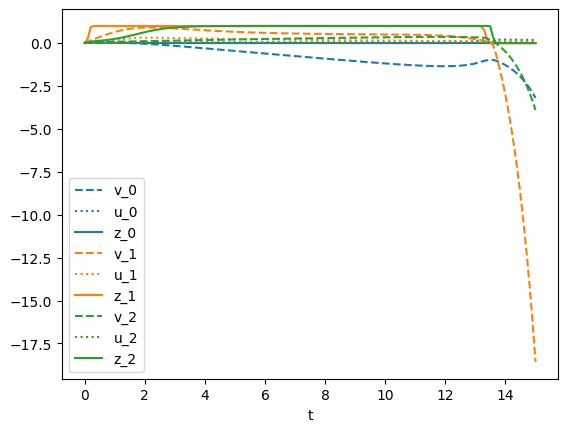

In [110]:
import matplotlib.colors as mcolors
COLORS = mcolors.TABLEAU_COLORS
COLORS = list(COLORS.values())

t = np.linspace(0, 15, 150)

v = np.array([0.0, 0.0, 0.0])
u = np.array([0.0, 0.0, 0.0])
I = np.array([0.2, 0.8, 0.4])
cumul_z = np.zeros(3)

params = {
    'N': 3,
    'tau': 1.0,
    'lambda': 1,
    'alpha': 0.9,
    'I': I,
    'phi': 0.00001,
    'rho': 0.1,
    'gamma': 0.1,
    'c': 0.5, # convert c to vector later
    'epsilon': 0.001,
    'beta': 50.0,
    'mu': 0.1
}

state = np.array((v, u, cumul_z)).reshape(3*params['N'])
print(state)
result = solve_ivp(fun=lambda t, state: doodle(t, state, params), t_span=(min(t), max(t)), t_eval=t, y0=state)
v_series = result.y[:3,]
z_series = transform(v_series, params['beta'], params['mu'])
u_series = result.y[3:,]

fig,ax = plt.subplots()
for i in range(params['N']):
    color = COLORS[i]
    ax.plot(t, v_series[i], label=f'v_{i}', c=color, linestyle='dashed')
    ax.plot(t, u_series[i], label=f'u_{i}', c=color, linestyle='dotted')
    ax.plot(t, z_series[i], label=f'z_{i}', c=color, linestyle='solid')

ax.legend()
# ax.set_ylim([0, 1])
ax.set_xlabel('t')
